In [26]:
#get data
import pandas as pd

file_path = 'sp500_data.csv'
sp500 = pd.read_csv(file_path, index_col='Date')


In [ ]:
#split data into train and test sets then train the model
from sklearn.ensemble import RandomForestClassifier

model= RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

#cant use cross-validation because of the time series nature of the data
train = sp500.iloc[:-100] # does not include the latest 100 rows
test = sp500.iloc[-100:] # includes the latest 100 rows

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']

model.fit(train[predictors], train['Target'])



,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,100
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# make predictions
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
# turn array into a pandas Series for better readability
preds = pd.Series(preds, index=test.index)
preds

Date
2025-03-20 00:00:00-04:00    0
2025-03-21 00:00:00-04:00    1
2025-03-24 00:00:00-04:00    1
2025-03-25 00:00:00-04:00    1
2025-03-26 00:00:00-04:00    1
                            ..
2025-08-06 00:00:00-04:00    0
2025-08-07 00:00:00-04:00    0
2025-08-08 00:00:00-04:00    0
2025-08-11 00:00:00-04:00    0
2025-08-12 00:00:00-04:00    0
Length: 100, dtype: int64

In [ ]:
# check the precision of the model
precision_score(test['Target'], preds)

0.6

<Axes: xlabel='Date'>

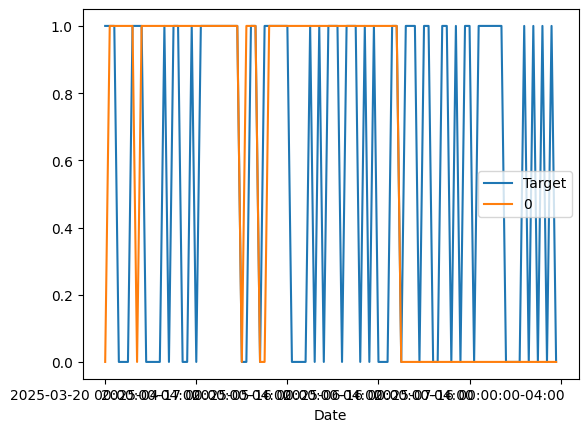

In [32]:
# combine predictions with actual target values for comparison
combined = pd.concat([test["Target"], preds], axis=1)

combined.plot()

In [37]:
# making commands into functions for better organization and reusability
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)

    return combined

In [ ]:
# function to back test the model
# start value is the number of rows to start the backtest from - first model will use 10 years of data
# step is the number of rows to step through the data - each year should be about 250 rows
def backtest(data, model, predictors,start=2500,step=250):
    all_predictions = []  # list to hold all predictions
    
    for i in range(start, data.shape[0], step): # loop from start to the end of the data in steps
        train = data.iloc[:i].copy() # training data is everything up to the current point
        test = data.iloc[i:(i+step)].copy() # testing data is the next 'step' rows
        predictions = predict(train, test, predictors, model) # get predictions
        all_predictions.append(predictions) # add predictions to the list

    return pd.concat(all_predictions) # return all predictions as a single DataFrame

In [ ]:
# run backtest
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

Predictions
0    3821
1    2648
Name: count, dtype: int64

In [41]:
precision_score(predictions["Target"], predictions["Predictions"])

0.525679758308157

In [42]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.536714
0    0.463286
Name: count, dtype: float64

In [ ]:
# improve model by creating new predictors based on rolling averages and trends, add them to the sp500 dataframe

horizons = [2,5,60,250,1000] # rolling windows of 2 days, trading week, 3 months, year, and 4 years
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean() # calculate rolling averages for the specified horizon
    ratio_column = f'Close_Ratio_{horizon}' # create a new column name based on the horizon
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close'] # calculate the ratio of the current close price to the rolling average close price
    
    trend_column = f'Trend_{horizon}' # create a new column name for the trend
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] # calculate the trend based on the previous values

    new_predictors += [ratio_column, trend_column] # add the new columns to the list of predictors


In [47]:
# new predictors cause NaN values in the first few rows, so we need to drop them
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-05 00:00:00-04:00,6336.629883,6346.000000,6289.370117,6299.189941,5517410000,6345.060059,1,0.997565,1.0,0.997672,1.0,1.032160,35.0,1.077533,144.0,1.315353,530.0
2025-08-06 00:00:00-04:00,6309.299805,6352.830078,6301.109863,6345.060059,5408560000,6340.000000,0,1.003628,1.0,1.005506,2.0,1.037735,36.0,1.084560,144.0,1.324405,530.0
2025-08-07 00:00:00-04:00,6374.319824,6389.709961,6310.319824,6340.000000,5306090000,6389.450195,1,0.999601,1.0,1.004684,2.0,1.035508,35.0,1.082850,144.0,1.322830,529.0


In [ ]:
# retrain the model with the new predictors
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
# lets return the probablility of 1 or 0 instead of just the prediction of 1 or 0
# manually creating a threshold of 0.6 to classify as 1 to make the model more conservative

def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6] = 1  # thresholding at 0.6 to classify as 1
    preds[preds<.6] = 0   # thresholding at 0.6 to classify as 0    
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)

    return combined

In [52]:
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    4599
1.0     869
Name: count, dtype: int64

In [53]:
precision_score(predictions["Target"], predictions["Predictions"]) 

0.5742232451093211